In [166]:
# -*- coding: utf-8 -*-
import os
from os import listdir
from sklearn.metrics import classification_report
from keras.metrics import categorical_accuracy 
from keras import layers
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Convolution1D
import utility
import warnings
from nltk.tokenize import regexp_tokenize
import gensim as gen
import nltk
import keras.backend as K
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Layer,Lambda, Dropout, Activation, Input, merge, Multiply, Embedding,GlobalMaxPooling1D 
from sklearn.ensemble import GradientBoostingClassifier
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
import tensorflow as tf
#from tensorflow.keras import layers
import numpy as np
import pandas as pd
from nltk.tokenize import regexp_tokenize
import numpy as np
import gensim as gen
from sklearn.metrics import confusion_matrix
import re
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
#from collections import defaultdict
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anh21\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anh21\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anh21\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#importing all stopwords
stop_words=stopwords.words('english')
stopwords=set(stop_words).union(STOP_WORDS)

In [3]:

tokenizer= RegexpTokenizer('\w+\'?\w+|w+')
#%%
directory="C:\\Users\\anh21\\Fake_news\\fake news challenge (FNC-1)\\Qatar_data\\"
train_folders=['legit-training\\','fake-training\\']
test_folders=['fake-test\\','legit-test\\']

#%% basic preprocessing
exceptionStopWords = {
    'again',
    'against',
    'ain',
    'almost',
    'among',
    'amongst',
    'amount',
    'anyhow',
    'anyway',
    'aren',
    "aren't",
    'below',
    'bottom',
    'but',
    'cannot',
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'done',
    'down',
    'except',
    'few',
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'however',
    'isn',
    "isn't",
    'least',
    'mightn',
    "mightn't",
    'must',
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'neither',
    'never',
    'nevertheless',
    'no',
    'nobody',
    'none', 'noone',
    'nor',
    'not',
    'nothing',
    'should',
    "should've",
    'shouldn',
    "shouldn't",
    'too',
    'top',
    'up',
    'wasn',
    "wasn't",
    'well',
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't",
}
finalstop = stopwords - exceptionStopWords

In [582]:

def load_dataset(folders,directory):
    
#     heading=defaultdict(list)
#     body=defaultdict(list)
#     toke_sentence=defaultdict(list)
    heading=[]
    body=[]
    domain=[]
    credibility=[]
    ids=0
    for folder in folders:
        for name in listdir(directory+folder):
            names=re.findall("[a-zA-Z]+",name)
            myfile = pd.read_csv(directory+folder+name,sep='\n\n', header=None,encoding='utf-8')
          
                #addressing one word title
            if len(tokenizer.tokenize(myfile[0][0]))<2:
                artic=myfile[0][1].replace('  ','\n').split('\n')
                heading.append((myfile[0][0]+' '+artic[0]).lower())
                body.append((' '.join(artic[1:])).lower())
             #addressing no title issue
            elif len(myfile)==1:
                 #artic=re.split('[\n!?."-]+',myfile[0][0])
                heading.append(np.nan)
                body.append(myfile[0][0].replace('\r','').lower())#(' '.join(artic[:])).replace('\r','').lower()
                
                 #to do: addressing hyperlinks   
            elif re.sub(r'^https?:\/\/.*[\r\n]*', '', myfile[0][0], flags=re.MULTILINE)=='':
                
                artic=myfile[0][1].split('.')
                heading.append((artic[0]).lower())
                body.append((' '.join(artic[1:])).lower())
                
            else:    
                heading.append(myfile[0][0].replace('\r','').lower())
                body.append(myfile[0][1].replace('\r','').lower())
             
            domain.append(names[0])
            credibility.append(names[1])   
            ids+=1
    df=pd.DataFrame(list(zip(body, heading,credibility,domain)), 
               columns =['Body', 'Heading','Credibility','Domain'])
    return df
print("Loading training data")
train_data=load_dataset(train_folders,directory)  
print("Loading testing data")
test_data=load_dataset(test_folders,directory)  
#%%
#domain_onehot=np.asarray(pd.get_dummies(domain), dtype = np.float32)

Loading training data
Loading testing data


In [583]:
#checking for null values
test_data.isnull().values.any()

False

In [584]:
test_data.head()

,Body,Heading,Credibility,Domain
0,yahoo and aol could be extremely popular over ...,breaking news: snapchat to purchase twitter fo...,fake,biz
1,"""the negotiations we are going great according...",brexit talks are seeing success: josé manuel b...,fake,biz
2,robots are slowly taking over the workforce of...,robots taking over the world,fake,biz
3,"""brewdog was recently found to include dog sal...",brewdog under fire for accusations of canine i...,fake,biz
4,in a ridiculous decision students with disabil...,supreme court forces schools into socialism,fake,edu


In [ ]:
test_data['Heading']

In [585]:
#shuffling training data
def shuffle(df, n=1, axis=1):    
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df
train_data_shuffled=shuffle(train_data, n=500, axis=1)

In [586]:
train_data_shuffled=train_data_shuffled.dropna()


In [587]:
train_data_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 383
Data columns (total 4 columns):
Body           356 non-null object
Heading        356 non-null object
Credibility    356 non-null object
Domain         356 non-null object
dtypes: object(4)
memory usage: 13.9+ KB


In [588]:
#preprocessing
from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()
# remove punctuations
def remove_punctuations(data):
    
    train = []
    for i in range(len(data)):
        sentence = ""
        for char in data[i]:
            
            if char.isalpha() or char== ' ':
                sentence+=char
            else:
                sentence+=' '
        train.append(sentence)
    return train

nlp = spacy.load("en",disable=['parser', 'tagger', 'ner'])

def lemmatization(review):
    lemma_result = []
    
    for words in review:
        doc = nlp(words)
        for token in doc:
            lemma_result.append(token.lemma_)

    return lemma_result

def remove_stopwords(sent):
    return [token for token in sent if token not in finalstop]





In [589]:
train_data_shuffled["Heading"]=train_data_shuffled["Heading"].apply(nltk.word_tokenize)
print(train_data_shuffled["Heading"].head())
train_data_shuffled["Heading"]=train_data_shuffled["Heading"].apply(lambda x: [lemma.lemmatize(i) for i in x])
print(train_data_shuffled["Heading"].head())
train_data_shuffled["Heading"]=train_data_shuffled["Heading"].apply(remove_stopwords)
print(train_data_shuffled["Heading"].head())
train_data_shuffled["Heading"]=train_data_shuffled["Heading"].apply(remove_punctuations).apply(lambda x: ' '.join(word for word in x))
print(train_data_shuffled["Heading"].head())

0      tesco to pay     m fine over accounting scandal
1    uber to shut down denmark operation over new t...
2    eu blocks deutsche boerse s     billion takeov...
3       toshiba s westinghouse files for us bankruptcy
4             ford to invest     bn in michigan plants
Name: Heading, dtype: object


In [590]:
# train_data_shuffled["Body"]=train_data_shuffled["Body"].apply(nltk.word_tokenize)
# print(train_data_shuffled["Body"].head())
# # train_data_shuffled["Body"]=train_data_shuffled["Body"].apply(lambda x: [lemma.lemmatize(i) for i in x])
# # print(train_data_shuffled["Body"].head())
# train_data_shuffled["Body"]=train_data_shuffled["Body"].apply(remove_stopwords)
# print(train_data_shuffled["Body"].head())
train_data_shuffled["Body"]=train_data_shuffled["Body"].apply(remove_punctuations).apply(lambda x: ''.join(word for word in x))
print(train_data_shuffled["Body"].head())

0    tesco is to pay out     m to settle investigat...
1    uber will shut down its operation in denmark n...
2    european union regulators dealt a final blow t...
3    westinghouse  toshiba s us nuclear unit  has f...
4    ford has said it will spend     bn    bn  as p...
Name: Body, dtype: object


In [591]:
# test_data["Heading"]=test_data["Heading"].apply(nltk.word_tokenize)
# print(test_data["Heading"].head())
# # test_data["Heading"]=test_data["Heading"].apply(lambda x: [lemma.lemmatize(i) for i in x])
# # print(test_data["Heading"].head())
# test_data["Heading"]=test_data["Heading"].apply(remove_stopwords)
# print(test_data["Heading"].head())
test_data["Heading"]=test_data["Heading"].apply(remove_punctuations).apply(lambda x: ''.join(word for word in x))
print(test_data["Heading"].head())

0    breaking news  snapchat to purchase twitter fo...
1    brexit talks are seeing success  josé manuel b...
2                         robots taking over the world
3    brewdog under fire for accusations of canine i...
4          supreme court forces schools into socialism
Name: Heading, dtype: object


In [592]:
# test_data["Body"]=test_data["Body"].apply(nltk.word_tokenize)
# print(test_data["Body"].head())
# # test_data["Body"]=test_data["Body"].apply(lambda x: [lemma.lemmatize(i) for i in x])
# # print(test_data["Body"].head())
# test_data["Body"]=test_data["Body"].apply(remove_stopwords)
# print(test_data["Body"].head())
test_data["Body"]=test_data["Body"].apply(remove_punctuations).apply(lambda x: ''.join(word for word in x))
print(test_data["Body"].head())

0    yahoo and aol could be extremely popular over ...
1     the negotiations we are going great according...
2    robots are slowly taking over the workforce of...
3     brewdog was recently found to include dog sal...
4    in a ridiculous decision students with disabil...
Name: Body, dtype: object


In [608]:
train_rdh= train_data_shuffled["Heading"].values
train_rdb=train_data_shuffled['Body'].values
test_rdh=test_data['Heading'].values
test_rdb=test_data['Body'].values
all_data=train_data_shuffled.append(test_data)

In [118]:
def word2vec_embedding_layer(embedding_matrix):
    
    layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix])
    return layer    

In [728]:
def generateMatrix(obj, sent_Q, sent_A,wordVec_model=None):
    START = '$_START_$'
    END = '$_END_$'
    unk_token = '$_UNK_$'
    dimx = 80
    dimy = 150
    sent1 = []
    #sent1_Q = ques_sent
    #sent1_A = ans_sent
    sent1.extend(sent_Q)
    #sent.extend(ques_sent)
    sent1.extend(sent_A)
    #sent1 = [' '.join(i) for i in sent1]
    #sent.extend(ans_sent)
    sentence = ["%s %s %s" % (START,x,END) for x in sent1]
    tokenize_sent = [regexp_tokenize(x, 
                                     pattern = '\w+|$[\d\.]+|\S+') for x in sentence]

        
    for i,sent in enumerate(tokenize_sent):
        tokenize_sent[i] = [w if w in obj.word_to_index else unk_token for w in sent]
        
    len_train = len(sent_Q)
    text=[]
    for i in tokenize_sent:
        text.extend(i)
        
    sentences_x = []
    sentences_y = []
        
        #print 'here' 
        
    for sent in tokenize_sent[0:len_train]:
        temp = [START for i in range(dimx)]
        for ind,word in enumerate(sent[0:dimx]):
            temp[ind] = word
        sentences_x.append(temp)
            
    for sent in tokenize_sent[len_train:]:
        temp = [START for i in range(dimy)]
        for ind,word in enumerate(sent[0:dimy]):
            temp[ind] = word       
        sentences_y.append(temp)
            
    X_data = []
    for i in sentences_x:
        temp = []
        for j in i:
            temp.append(obj.word_to_index[j])
        temp = np.array(temp).T
        X_data.append(temp)
        
    y_data=[]
    for i in sentences_y:
        temp = []
        for j in i:
            temp.append(obj.word_to_index[j])
        temp = np.array(temp).T
        y_data.append(temp)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

### Google news embeddings

In [ ]:
path="C:\\Users\\anh21\\Fake_news\\fake news challenge (FNC-1)\\"
wordVec_model = gen.models.KeyedVectors.load_word2vec_format("C:\\Users\\anh21\\Fake_news\\fake news challenge (FNC-1)\\fncdata\\GoogleNews-vectors-negative300.bin",binary=True)

In [594]:


def trainCNN(obj, dataset_headLines, dataset_body,num_outs):
    embedding_dim = 300
    dense_neuron = 16
    dimx = 80
    dimy = 150
    filter_length = 4
    batch_size = 50
   
    train_head,train_body,embedding_matrix = obj.process_data(sent_Q=dataset_headLines,
                                                     sent_A=dataset_body,dimx=dimx,dimy=dimy,
                                                     wordVec_model = wordVec_model)    
    inpx = Input(shape=(dimx,),dtype='int32',name='inpx')
    #x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimx)(inpx)
    x = word2vec_embedding_layer(embedding_matrix)(inpx)  
    inpy = Input(shape=(dimy,),dtype='int32',name='inpy')
    #y = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimy)(inpy)
    y = word2vec_embedding_layer(embedding_matrix)(inpy)
    
    ques = Convolution1D(filters=100, kernel_size=filter_length,
                         padding='same', activation='relu'
                         )(x)
                            
    ans = Convolution1D(filters=100, kernel_size=filter_length,
                        padding='same', activation='relu')(y)
            
    hx = GlobalMaxPooling1D()(ques)
    hy = GlobalMaxPooling1D()(ans)

    h1 = Multiply()([hx,hy])
    h2 = Abs()([hx,hy])

    h =  merge.Concatenate()([h1,h2])
 
    wrap = Dense(dense_neuron, activation='relu',name='wrap')(h)
    #Dropout_layer = layers.Dropout(0.1)(wrap)
    
    score = Dense(num_outs,activation='softmax',name='score')(wrap)

    model = Model( [inpx,inpy],score)
    model.compile( loss='categorical_crossentropy',optimizer="adadelta",metrics=[categorical_accuracy])    
    return model,train_head,train_body




In [389]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [485]:
import random
import warnings
import itertools
import keras.backend as K
import scipy.stats as measures
from gensim.models import word2vec
from scipy.stats.stats import pearsonr
from keras.engine.topology import Layer
from nltk.tokenize import regexp_tokenize
from sklearn.metrics.pairwise import cosine_similarity
warnings.simplefilter("ignore")

START = '$_START_$'
END = '$_END_$'
unk_token = '$_UNK_$'

#wordVec_model = word2vec.Word2Vec.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",binary=True)
class sample:
    def __init__(self,vocab_size):
        print("Inside utility")
    def process_data(self,sent_Q,sent_A,wordVec_model=None,dimx=100,dimy=100,vocab_size=5200,embedding_dim=300):
    #if True:
        sent1 = []
        sent1.extend(sent_Q)
        sent1.extend(sent_A)
        sentence = ["%s %s %s" % (START,x,END) for x in sent1]
        self.tokenize_sent = [regexp_tokenize(x, 
                                         pattern = '\w+|$[\d\.]+|\S+') for x in sentence]
                        
        freq = nltk.FreqDist(itertools.chain(*self.tokenize_sent))
        print('found ',len(freq),' unique words')
        
        vocab = freq.most_common(vocab_size - 1)
        self.index_to_word = [x[0] for x in vocab]
        self.index_to_word.append(unk_token)
    
        
        self.word_to_index = dict([(w,i) for i,w in enumerate(self.index_to_word)])
       
  
        for i,sent in enumerate(self.tokenize_sent):
            self.tokenize_sent[i] = [w if w in self.word_to_index else unk_token for w in sent]
        
        self.len_train = len(sent_Q)
#        text=[]
#        for i in self.tokenize_sent:
#            text.extend(i)
        
        self.sentences_x = []
        self.sentences_y = []
        
        #print 'here' 
        
        for sent in self.tokenize_sent[0:self.len_train]:
            temp = [START for i in range(dimx)]
            for ind,word in enumerate(sent[0:dimx]):
                temp[ind] = word
            self.sentences_x.append(temp)
        # before this loop remove stop words     
        for sent in self.tokenize_sent[self.len_train:]:
            temp = [START for i in range(dimy)]
            for ind,word in enumerate(sent[0:dimy]):
                temp[ind] = word       
            self.sentences_y.append(temp)
            
        X_data = []
        for i in self.sentences_x:
            temp = []
            for j in i:
                temp.append(self.word_to_index[j])
            temp = np.array(temp).T
            X_data.append(temp)
        
        y_data=[]
        for i in self.sentences_y:
            temp = []
            for j in i:
                temp.append(self.word_to_index[j])
            temp = np.array(temp).T
            y_data.append(temp)
        
        X_data = np.array(X_data)
        y_data = np.array(y_data)
        
        #model = gen.models.Word2Vec.load('Word2Vec_QA')  
       # pdb.set_trace()
        embedding_matrix = np.zeros((len(self.index_to_word)+1,embedding_dim))  
        
        unk = []
        for i,j in enumerate(self.index_to_word):
            try:
                embedding_matrix[i] = wordVec_model[j]
            except:
                #embedding_matrix[i] = np.zeros_like()
                
                unk.append(j)
                continue
        print('number of unkown words: ',len(unk))
        print('some unknown words ',unk[0:5])
        return X_data,y_data,embedding_matrix

In [109]:
dimx=len(train_data_shuffled['Heading'].max())
dimy=len(train_data_shuffled['Body'].max())

In [ ]:
domains = ['biz', 'edu',"entmt","polit","sports","tech"]
def evaluation(y_test,y_pred,target_names):
    y_pred=np.argmax(y_pred,axis=1) 
    y_test=np.argmax(y_test,axis=1)

    print()
    print(classification_report(y_test, y_pred, target_names=target_names))

def confusion_mat( y_test,y_pred,LABELS):
    y_pred=np.argmax(y_pred,axis=1) 
    y_test=np.argmax(y_test,axis=1)
    c=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(c, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_results(history):   
    plt.figure(figsize=(8,4))
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.figure(figsize=(8,4))
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

##### Domain of the news prediction

In [604]:
#%%
obj=sample(6000)
print("Training CNN")
model,tr_head,tr_body = trainCNN(obj, train_rdh,train_rdb,6)

Inside utility
Training CNN
found  6038  unique words
number of unkown words:  291
some unknown words  ['to', 'a', 'of', 'and', '$_START_$']


In [605]:
Y_train = np.asarray(pd.get_dummies(train_data_shuffled['Domain'].values), dtype = np.float32)
Y_test = np.asarray(pd.get_dummies(test_data['Domain'].values), dtype = np.float32)

hist=model.fit([tr_head,tr_body],Y_train, nb_epoch = 4,verbose=1)
ts_head, ts_body = generateMatrix(obj,test_rdh, test_rdb)
print ('\n model trained....\n')
predictions = model.predict([ts_head, ts_body])
predictions = np.array(predictions)

Epoch 1/4
356/356 [==============================] - ETA: 1:20 - loss: 1.7704 - categorical_accuracy: 0.18 - ETA: 14s - loss: 1.7736 - categorical_accuracy: 0.2344 - ETA: 3s - loss: 1.7454 - categorical_accuracy: 0.277 - 8s 23ms/step - loss: 1.7133 - categorical_accuracy: 0.3174
Epoch 2/4
356/356 [==============================] - ETA: 0s - loss: 1.3869 - categorical_accuracy: 0.50 - ETA: 0s - loss: 1.2434 - categorical_accuracy: 0.62 - ETA: 0s - loss: 1.1706 - categorical_accuracy: 0.68 - 0s 471us/step - loss: 1.1601 - categorical_accuracy: 0.6826
Epoch 3/4
356/356 [==============================] - ETA: 0s - loss: 0.7568 - categorical_accuracy: 1.00 - ETA: 0s - loss: 0.6624 - categorical_accuracy: 0.97 - ETA: 0s - loss: 0.6199 - categorical_accuracy: 0.97 - 0s 479us/step - loss: 0.5934 - categorical_accuracy: 0.9803
Epoch 4/4
356/356 [==============================] - ETA: 0s - loss: 0.3479 - categorical_accuracy: 1.00 - ETA: 0s - loss: 0.2798 - categorical_accuracy: 1.00 - ETA: 0s -

In [606]:
evaluation(Y_test,predictions,domains)


              precision    recall  f1-score   support

         biz       0.53      1.00      0.70         8
         edu       1.00      1.00      1.00         8
       entmt       0.62      0.62      0.62         8
       polit       1.00      1.00      1.00         8
      sports       1.00      0.75      0.86         8
        tech       1.00      0.38      0.55         8

    accuracy                           0.79        48
   macro avg       0.86      0.79      0.79        48
weighted avg       0.86      0.79      0.79        48



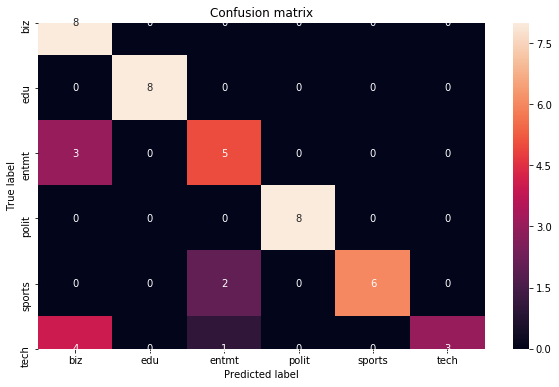

In [607]:
 confusion_mat(Y_test,predictions,domains)

#### Credibility prediction

In [571]:
def trainCNN(obj, dataset_headLines, dataset_body,num_outs):
    embedding_dim = 300
    dense_neuron = 16
    dimx = 80
    dimy = 150
    filter_length = 4
    batch_size = 64
    ntn_out = 16

    
    
    train_head,train_body,embedding_matrix = obj.process_data(sent_Q=dataset_headLines,
                                                     sent_A=dataset_body,dimx=dimx,dimy=dimy,
                                                     wordVec_model = wordVec_model)    
    inpx = Input(shape=(dimx,),dtype='int32',name='inpx')
    #x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimx)(inpx)
    x = word2vec_embedding_layer(embedding_matrix)(inpx)  
    inpy = Input(shape=(dimy,),dtype='int32',name='inpy')
    #y = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimy)(inpy)
    y = word2vec_embedding_layer(embedding_matrix)(inpy)
    ques = Convolution1D(filters=64, kernel_size=filter_length,
                         padding='same', activation='relu',
                         subsample_length=1)(x)
                            
    ans = Convolution1D(filters=64, kernel_size=filter_length,
                        padding='same', activation='relu',
                        subsample_length=1)(y)
            
    hx = GlobalMaxPooling1D()(ques)
    hy = GlobalMaxPooling1D()(ans)

    h1 = Multiply()([hx,hy])
    h2 = Abs()([hx,hy])

    h =  merge.Concatenate()([h1,h2])
    wrap = Dense(dense_neuron, activation='relu',name='wrap')(h)
    Dropout_layer = layers.Dropout(0.1)(wrap)
    score = Dense(num_outs,activation='softmax',name='score')(wrap)
    model = Model( [inpx,inpy],score)
    model.compile( loss='categorical_crossentropy',optimizer="adam",metrics=[f1])    
    return model,train_head,train_body
# predicting the cridibility of the news
model,tr_head,tr_body = trainCNN(obj, train_rdh,train_rdb,2)
Y_train = np.asarray(pd.get_dummies(train_data_shuffled['Credibility'].values), dtype = np.float32)
Y_test = np.asarray(pd.get_dummies(test_data['Credibility'].values), dtype = np.float32)

model.fit([tr_head,tr_body],Y_train, nb_epoch =4 ,verbose=1)
ts_head, ts_body = generateMatrix(obj,test_rdh, test_rdb)
predictions = model.predict([ts_head, ts_body])

found  5835  unique words
number of unkown words:  299
some unknown words  ['$_START_$', '$_END_$', 'westinghouse', 'brexit', 'boerse']
Epoch 1/4
356/356 [==============================] - ETA: 1:15 - loss: 0.6525 - f1: 0.62 - ETA: 13s - loss: 0.6972 - f1: 0.5547 - ETA: 2s - loss: 0.7024 - f1: 0.500 - 8s 21ms/step - loss: 0.7038 - f1: 0.5028
Epoch 2/4
356/356 [==============================] - ETA: 0s - loss: 0.5151 - f1: 0.87 - ETA: 0s - loss: 0.5034 - f1: 0.95 - ETA: 0s - loss: 0.4826 - f1: 0.95 - 0s 471us/step - loss: 0.4772 - f1: 0.9551
Epoch 3/4
356/356 [==============================] - ETA: 0s - loss: 0.3840 - f1: 1.00 - ETA: 0s - loss: 0.3246 - f1: 0.99 - ETA: 0s - loss: 0.3095 - f1: 0.97 - 0s 465us/step - loss: 0.3059 - f1: 0.9691
Epoch 4/4
356/356 [==============================] - ETA: 0s - loss: 0.2137 - f1: 1.00 - ETA: 0s - loss: 0.1930 - f1: 0.98 - ETA: 0s - loss: 0.1734 - f1: 0.98 - 0s 460us/step - loss: 0.1686 - f1: 0.9888


In [572]:
predictions = np.array(predictions)
evaluation(Y_test,predictions,['l','f'])


              precision    recall  f1-score   support

           l       0.59      0.42      0.49        24
           f       0.55      0.71      0.62        24

    accuracy                           0.56        48
   macro avg       0.57      0.56      0.55        48
weighted avg       0.57      0.56      0.55        48



### Fast Text Embeddings

In [182]:
import string
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open(path+'fncdata\\crawl-300d-2M.vec',encoding='utf-8')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [569]:
# predicting the cridibility of the news
def trainCNN(obj, dataset_headLines, dataset_body,num_outs):
    embedding_dim = 300
    dense_neuron = 16
    dimx = 80
    dimy = 150
    filter_length = 4
    batch_size = 64
    ntn_out = 16

    train_head,train_body,embedding_matrix = obj.process_data(sent_Q=dataset_headLines,
                                                     sent_A=dataset_body,dimx=dimx,dimy=dimy,
                                                     wordVec_model = embeddings_index)    
    inpx = Input(shape=(dimx,),dtype='int32',name='inpx')
    #x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimx)(inpx)
    x = word2vec_embedding_layer(embedding_matrix)(inpx)  
    inpy = Input(shape=(dimy,),dtype='int32',name='inpy')
    #y = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimy)(inpy)
    y = word2vec_embedding_layer(embedding_matrix)(inpy)
    ques = Convolution1D(filters=64, kernel_size=filter_length,
                         padding='same', activation='relu',
                         subsample_length=1)(x)
                            
    ans = Convolution1D(filters=64, kernel_size=filter_length,
                        padding='same', activation='relu',
                        subsample_length=1)(y)
            
    hx = GlobalMaxPooling1D()(ques)
    hy = GlobalMaxPooling1D()(ans)

    h1 = Multiply()([hx,hy])
    h2 = Abs()([hx,hy])

    h =  merge.Concatenate()([h1,h2])
    wrap = Dense(dense_neuron, activation='relu',name='wrap')(h)
   # Dropout_layer = layers.Dropout(0.1)(wrap)
    score = Dense(num_outs,activation='softmax',name='score')(wrap)
    model = Model( [inpx,inpy],score)
    model.compile( loss='categorical_crossentropy',optimizer="adam",metrics=[f1])    
 
    return model,train_head,train_body


model,tr_head,tr_body = trainCNN(obj, train_rdh,train_rdb,2)
Y_train = np.asarray(pd.get_dummies(train_data_shuffled['Credibility'].values), dtype = np.float32)
Y_test = np.asarray(pd.get_dummies(test_data['Credibility'].values), dtype = np.float32)

model.fit([tr_head,tr_body],Y_train, nb_epoch =4,verbose=1)
predictions = model.predict([ts_head, ts_body])

found  5835  unique words
number of unkown words:  105
some unknown words  ['$_START_$', '$_END_$', 'boerse', 'tencent', 'calipari']
Epoch 1/4
356/356 [==============================] - ETA: 1:17 - loss: 0.7091 - f1: 0.53 - ETA: 9s - loss: 0.7003 - f1: 0.5125 - ETA: 1s - loss: 0.7022 - f1: 0.52 - 8s 22ms/step - loss: 0.7043 - f1: 0.5225
Epoch 2/4
356/356 [==============================] - ETA: 0s - loss: 0.6060 - f1: 0.65 - ETA: 0s - loss: 0.6044 - f1: 0.68 - ETA: 0s - loss: 0.5880 - f1: 0.73 - 0s 459us/step - loss: 0.5855 - f1: 0.7444
Epoch 3/4
356/356 [==============================] - ETA: 0s - loss: 0.4472 - f1: 1.00 - ETA: 0s - loss: 0.4548 - f1: 0.95 - ETA: 0s - loss: 0.4558 - f1: 0.93 - 0s 451us/step - loss: 0.4573 - f1: 0.9298
Epoch 4/4
356/356 [==============================] - ETA: 0s - loss: 0.3043 - f1: 1.00 - ETA: 0s - loss: 0.3041 - f1: 0.97 - ETA: 0s - loss: 0.3053 - f1: 0.97 - 0s 457us/step - loss: 0.3046 - f1: 0.9803


In [570]:
predictions = np.array(predictions)
evaluation(Y_test,predictions,['l','f'])


              precision    recall  f1-score   support

           l       0.58      0.62      0.60        24
           f       0.59      0.54      0.57        24

    accuracy                           0.58        48
   macro avg       0.58      0.58      0.58        48
weighted avg       0.58      0.58      0.58        48



### Bidirectional LSTM model

In [364]:
# predicting the cridibility of the news
def trainBiLSTM(obj, dataset_headLines, dataset_body,num_outs):
    embedding_dim = 300
    dense_neuron = 16
    dimx = 70
    dimy = 110
    batch_size = 32
    LSTM_neurons=32

    train_head,train_body,embedding_matrix = obj.process_data(sent_Q=dataset_headLines,
                                                     sent_A=dataset_body,dimx=dimx,dimy=dimy,
                                                     wordVec_model = embeddings_index)    
    inpx = Input(shape=(dimx,),dtype='int32',name='inpx')
    #x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimx)(inpx)
    x = word2vec_embedding_layer(embedding_matrix)(inpx)  
    inpy = Input(shape=(dimy,),dtype='int32',name='inpy')
    #y = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimy)(inpy)
    y = word2vec_embedding_layer(embedding_matrix)(inpy)
    shared_lstm = Bidirectional(LSTM(LSTM_neurons,return_sequences=True),merge_mode='sum')   
    #shared_lstm = LSTM(LSTM_neurons,return_sequences=True)    
    hx = shared_lstm(x)
    #hx = Dropout(0.1)(hx)
    hy = shared_lstm(y)
    #hy = Dropout(0.1)(hy)
    
    h1 = Multiply()([hx,hy])
    h2 = Abs()([hx,hy])

    h =  merge.Concatenate()([h1,h2,hy])
    wrap = layers.TimeDistributed(Dense(dense_neuron, activation='relu',name='wrap'))(h)
    Dropout_layer = layers.Dropout(0.2)(wrap)
    score = layers.TimeDistributed(Dense(num_outs,activation='softmax',name='score'))(Dropout_layer)
    model = Model( [inpx,inpy],score)
    model.compile( loss='categorical_crossentropy',optimizer="adam",metrics=[f1])    
 
    return model,train_head,train_body


model,tr_head,tr_body = trainCNN(obj, train_rdh,train_rdb,2)
Y_train = np.asarray(pd.get_dummies(train_data_shuffled['Credibility'].values), dtype = np.float32)
Y_test = np.asarray(pd.get_dummies(test_data['Credibility'].values), dtype = np.float32)

hist = model.fit([tr_head,tr_body],Y_train, nb_epoch =8,validation_data=[[ts_head, ts_body],Y_test],verbose=1)
predictions = model.predict([ts_head, ts_body])

predictions = np.array(predictions)
evaluation(Y_test,predictions,['l','f'])

found  6028  unique words
number of unkown words:  100
some unknown words  ['$_START_$', '$_END_$', 'boerse', 'tencent', 'calipari']
Train on 356 samples, validate on 48 samples
Epoch 1/8
356/356 [==============================] - ETA: 44s - loss: 0.7022 - f1: 0.500 - ETA: 3s - loss: 0.7157 - f1: 0.458 - ETA: 0s - loss: 0.7122 - f1: 0.48 - 5s 15ms/step - loss: 0.7115 - f1: 0.4831 - val_loss: 0.6936 - val_f1: 0.5417
Epoch 2/8
356/356 [==============================] - ETA: 0s - loss: 0.6078 - f1: 0.78 - ETA: 0s - loss: 0.6320 - f1: 0.69 - ETA: 0s - loss: 0.6233 - f1: 0.69 - 0s 395us/step - loss: 0.6239 - f1: 0.6966 - val_loss: 0.6901 - val_f1: 0.5625
Epoch 3/8
356/356 [==============================] - ETA: 0s - loss: 0.5458 - f1: 0.87 - ETA: 0s - loss: 0.5452 - f1: 0.85 - ETA: 0s - loss: 0.5414 - f1: 0.84 - 0s 389us/step - loss: 0.5393 - f1: 0.8511 - val_loss: 0.6894 - val_f1: 0.5208
Epoch 4/8
356/356 [==============================] - ETA: 0s - loss: 0.4633 - f1: 0.93 - ETA: 0s - loss

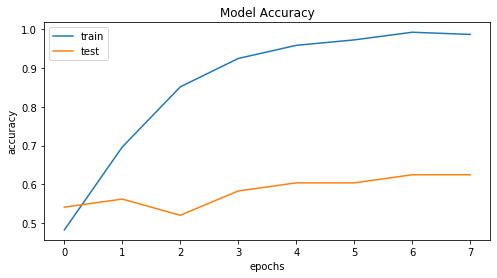

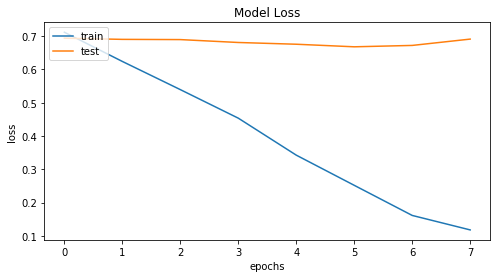

In [371]:
plot_results(hist)

In [628]:
all_data=train_data.append(test_data)
data=all_data['Body'].append(all_data['Heading'])

In [678]:
from keras.preprocessing import text, sequence
token = text.Tokenizer()
token.fit_on_texts(data)
word_index = token.word_index
index_word=token.index_word

In [682]:
START = '$_START_$'
END = '$_END_$'
unk_token = '$_UNK_$'
i=len(index_word)
index_word[i+1]=START
index_word[i+2]=END
index_word[i+3]=unk_token
        
word_index[START]=i+1
word_index[END]=i+2
word_index[unk_token]=i+3

In [725]:
import random
import warnings
import itertools
import keras.backend as K
import scipy.stats as measures
from gensim.models import word2vec
from scipy.stats.stats import pearsonr
from keras.engine.topology import Layer
from nltk.tokenize import regexp_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing import text, sequence
warnings.simplefilter("ignore")

START = '$_START_$'
END = '$_END_$'
unk_token = '$_UNK_$'

#wordVec_model = word2vec.Word2Vec.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",binary=True)
class sample:
    def __init__(self,vocab_size):
        print("Inside utility")
    def process_data(self,word_to_index,index_to_word,sent_Q,sent_A,wordVec_model=None,dimx=100,dimy=100,vocab_size=5200,embedding_dim=300):
    #train data
        self.word_to_index=word_to_index
        self.index_to_word=index_to_word
        sent_train= []
        sent_train.extend(sent_Q)
        sent_train.extend(sent_A)
        sentence = ["%s %s %s" % (START,x,END) for x in sent_train]
        self.tokenize_sent = [regexp_tokenize(x, 
                                         pattern = '\w+|$[\d\.]+|\S+') for x in sentence]
        
       
        
        freq = nltk.FreqDist(itertools.chain(*self.tokenize_sent))
        print('found ',len(freq),' unique words')
        
        for i,sent in enumerate(self.tokenize_sent):
            self.tokenize_sent[i] = [w if w in self.word_to_index else unk_token for w in sent]
        
        self.len_train = len(sent_Q)
        
        self.sentences_x = []
        self.sentences_y = []
        
        #print 'here' 
        
        for sent in self.tokenize_sent[0:self.len_train]:
            temp = [START for i in range(dimx)]
            for ind,word in enumerate(sent[0:dimx]):
                temp[ind] = word
            self.sentences_x.append(temp)
        # before this loop remove stop words     
        for sent in self.tokenize_sent[self.len_train:]:
            temp = [START for i in range(dimy)]
            for ind,word in enumerate(sent[0:dimy]):
                temp[ind] = word       
            self.sentences_y.append(temp)
 
        X_data = []
        for i in self.sentences_x:
            temp = []
            for j in i:
                temp.append(self.word_to_index[j])
            temp = np.array(temp).T
            X_data.append(temp)
        
        y_data=[]
        for i in self.sentences_y:
            temp = []
            for j in i:
                temp.append(self.word_to_index[j])
            temp = np.array(temp).T
            y_data.append(temp)
        
        X_data = np.array(X_data)
        y_data = np.array(y_data)
        
        #model = gen.models.Word2Vec.load('Word2Vec_QA')  
       # pdb.set_trace()
        embedding_matrix = np.zeros((len(self.index_to_word)+1,embedding_dim))  
        
        unk = []
        for i in self.index_to_word:
            try:
                embedding_matrix[i] = wordVec_model[self.index_to_word[i]]
            except:
                #embedding_matrix[i] = np.zeros_like()
                
                unk.append(self.index_to_word[i])
                continue
        print('number of unkown words: ',len(unk))
        print('some unknown words ',unk[0:5])
        return X_data,y_data,embedding_matrix,unk

In [ ]:

def trainCNN(obj, dataset_headLines, dataset_body,num_outs,embedding_matrix):
    embedding_dim = 300
    dense_neuron = 32
    
    filter_length = 5
    batch_size = 64
   
       
    inpx = Input(shape=(dimx,),dtype='int32',name='inpx')
    #x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimx)(inpx)
    x = word2vec_embedding_layer(embedding_matrix)(inpx)  
    inpy = Input(shape=(dimy,),dtype='int32',name='inpy')
    #y = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=dimy)(inpy)
    y = word2vec_embedding_layer(embedding_matrix)(inpy)
    
    ques = Convolution1D(filters=16, kernel_size=filter_length,
                         padding='same', activation='relu'
                         )(x)
    
                            
    ans = Convolution1D(filters=16, kernel_size=filter_length,
                        padding='same', activation='relu')(y)
            
    hx = GlobalMaxPooling1D()(ques)
    hy = GlobalMaxPooling1D()(ans)

    h1 = Multiply()([hx,hy])
    h2 = Abs()([hx,hy])

    h =  merge.Concatenate()([h1,h2,hy])
 
    wrap = Dense(dense_neuron, activation='relu',name='wrap')(h)
    #Dropout_layer = layers.Dropout(0.1)(wrap)
    
    score = Dense(num_outs,activation='softmax',name='score')(wrap)

    model = Model( [inpx,inpy],score)
    model.compile( loss='categorical_crossentropy',optimizer="adam",metrics=[f1])    
    return model,train_head,train_body,unk




In [ ]:
obj=sample(6000)
print("Training CNN")
dimx = 80
dimy = 150
train_head,train_body,embedding_matrix,unk = obj.process_data(word_index,index_word,sent_Q=train_rdh,
                                                     sent_A=train_rdb,dimx=dimx,dimy=dimy,
                                                     wordVec_model = embeddings_index) 


In [762]:
model,tr_head,tr_body,unk = trainCNN(obj,train_rdh,train_rdb,2,embedding_matrix)

In [763]:
Y_train = np.asarray(pd.get_dummies(train_data_shuffled['Credibility'].values), dtype = np.float32)
Y_test = np.asarray(pd.get_dummies(test_data['Credibility'].values), dtype = np.float32)
ts_head, ts_body = generateMatrix(obj,test_rdh, test_rdb)
hist = model.fit([tr_head,tr_body],Y_train, nb_epoch =10,validation_data=([ts_head, ts_body], Y_test),verbose=1)
predictions = model.predict([ts_head, ts_body])

predictions = np.array(predictions)
evaluation(Y_test,predictions,['l','f'])

Train on 356 samples, validate on 48 samples
Epoch 1/40
356/356 [==============================] - ETA: 1:29 - loss: 0.7097 - categorical_accuracy: 0.50 - ETA: 10s - loss: 0.7124 - categorical_accuracy: 0.5000 - ETA: 2s - loss: 0.7109 - categorical_accuracy: 0.496 - 10s 29ms/step - loss: 0.7125 - categorical_accuracy: 0.4719 - val_loss: 0.6868 - val_categorical_accuracy: 0.5417
Epoch 2/40
356/356 [==============================] - ETA: 0s - loss: 0.6111 - categorical_accuracy: 0.84 - ETA: 0s - loss: 0.5938 - categorical_accuracy: 0.81 - ETA: 0s - loss: 0.5947 - categorical_accuracy: 0.78 - 0s 513us/step - loss: 0.5961 - categorical_accuracy: 0.7753 - val_loss: 0.8098 - val_categorical_accuracy: 0.5000
Epoch 3/40
356/356 [==============================] - ETA: 0s - loss: 0.6243 - categorical_accuracy: 0.50 - ETA: 0s - loss: 0.4903 - categorical_accuracy: 0.85 - ETA: 0s - loss: 0.4849 - categorical_accuracy: 0.83 - 0s 558us/step - loss: 0.4816 - categorical_accuracy: 0.8315 - val_loss: 0

356/356 [==============================] - ETA: 0s - loss: 0.0018 - categorical_accuracy: 1.00 - ETA: 0s - loss: 0.0010 - categorical_accuracy: 1.00 - ETA: 0s - loss: 9.0632e-04 - categorical_accuracy: 1.00 - 0s 527us/step - loss: 9.0821e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8048 - val_categorical_accuracy: 0.6042
Epoch 26/40
356/356 [==============================] - ETA: 0s - loss: 6.8851e-04 - categorical_accuracy: 1.00 - ETA: 0s - loss: 7.3756e-04 - categorical_accuracy: 1.00 - ETA: 0s - loss: 8.2153e-04 - categorical_accuracy: 1.00 - 0s 524us/step - loss: 7.8215e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8778 - val_categorical_accuracy: 0.6250
Epoch 27/40
356/356 [==============================] - ETA: 0s - loss: 6.9300e-04 - categorical_accuracy: 1.00 - ETA: 0s - loss: 6.8010e-04 - categorical_accuracy: 1.00 - ETA: 0s - loss: 6.9363e-04 - categorical_accuracy: 1.00 - 0s 524us/step - loss: 6.5989e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8951 - val_categori

### Feature Based Approach

'$_START_$'